# Spam Check Model
## Import Libraries

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from model import Modelling
from utility import (
    DataPreprocessing,
    Visualisation, 
    Loader,
)

# !pip install mlflow
import mlflow
from mlflow.models import infer_signature

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yantingchn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Import Data & Data Analysis
Source: https://www.kaggle.com/datasets/venky73/spam-mails-dataset

In [2]:
loader = Loader()
df = loader.load_df()
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


ham     3672
spam    1499
Name: label, dtype: int64


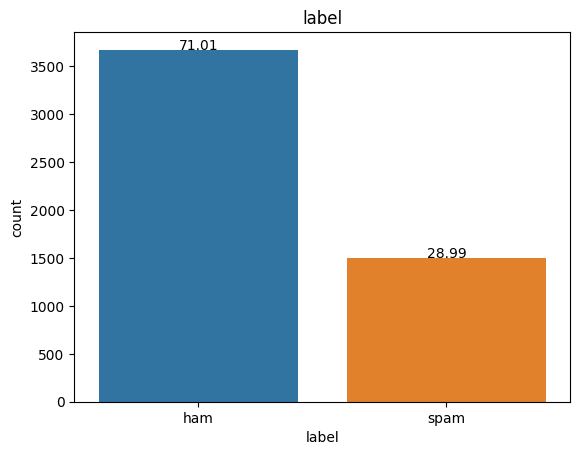

In [3]:
visualiser = Visualisation()
visualiser.ClaimCountBarChart(df, 'label')
print(df['label'].value_counts())

In [4]:
avg_sms_len=round(sum([len(i.split()) for i in df['text']])/len(df['text']))

s = set()
for sent in df['text']:
  for word in DataPreprocessing().tokenization(sent):
    s.add(word)
Unique_wd_cnt =len(s)

print('Average SMS length:', avg_sms_len)
print('Unique word count', Unique_wd_cnt)

Average SMS length: 228
Unique word count 50483


## Model Training
Model traing with pycaret and model register with MLFlow.

In [5]:
X, y = df['text'], df['label'].to_numpy()

### Vectorizer
Initialize vectorizer (**CountVectorizer**)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

# initialize data preprocessing
preprocessor = DataPreprocessing()

# # initialize vectorizer
vect = CountVectorizer(tokenizer=preprocessor.tokenization, stop_words=preprocessor.stop_words)
# vect = TfidfVectorizer(tokenizer=preprocessor.tokenization_nltk, stop_words=preprocessor.stop_words)

vect.fit(X_train)

pipeline = Modelling()

/Users/yantingchn/opt/miniconda3/envs/zilo/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### Setup
Initializes the training environment and creates the transformation pipeline.

In [7]:
from pycaret.classification import *

s = setup(data = vect.transform(X), target = pipeline.le.transform(y), session_id = 123, fold = 3)

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(4136, 37782)"
4,Transformed data shape,"(4136, 37782)"
5,Transformed train set shape,"(2895, 37782)"
6,Transformed test set shape,"(1241, 37782)"
7,Numeric features,37781
8,Preprocess,True
9,Imputation type,simple


In [8]:
from pycaret.classification import ClassificationExperiment
# init setup on experiment
exp = ClassificationExperiment()
exp.setup(data=vect.transform(X), target = pipeline.le.transform(y), session_id = 123)

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(4136, 37782)"
4,Transformed data shape,"(4136, 37782)"
5,Transformed train set shape,"(2895, 37782)"
6,Transformed test set shape,"(1241, 37782)"
7,Numeric features,37781
8,Preprocess,True
9,Imputation type,simple


### Compare Models
Trains and evaluates the performance of selected models (`Logistic Regression`, `Random Forest`, `MultinomialNB`) using cross-validation.

In [9]:
nb = MultinomialNB()
select_models = ['lr', 'rf', nb]
best = compare_models(include=select_models, sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
2,MultinomialNB,0.9734,0.9940,0.9545,0.9534,0.9540,0.9353,0.9353,9.4567
0,Logistic Regression,0.9710,0.9911,0.9773,0.9264,0.9511,0.9305,0.9313,8.5333
1,Random Forest Classifier,0.9665,0.9902,0.9725,0.9166,0.9437,0.9199,0.9207,8.1133


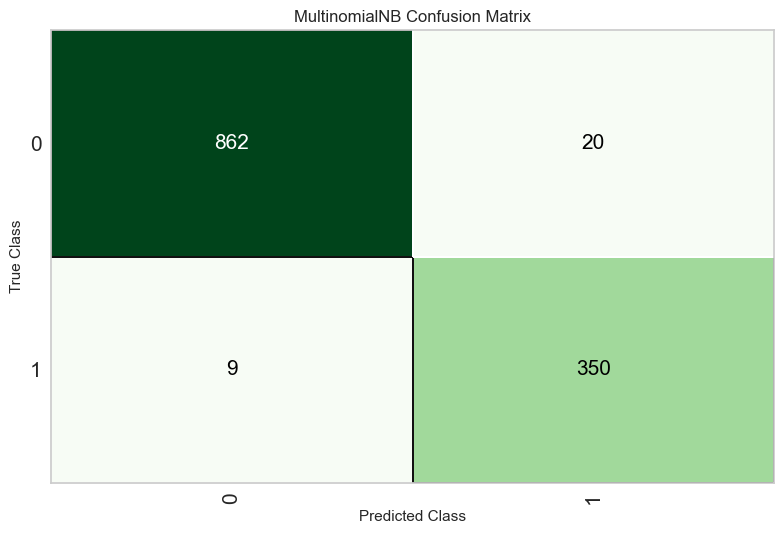

In [13]:
plot_model(best, plot = 'confusion_matrix')

### Model Registeration
Model registration with MLflow.

In [12]:
mlflow.sklearn.autolog()

# Pull the evaluation results
compared_result = pull()

with mlflow.start_run():
    mlflow.log_param("avg_sms_len", avg_sms_len)
    mlflow.log_param("Unique_wd_cnt", Unique_wd_cnt)

    artifact_path="sklearn-model"
    model_name="sk-learn-count-model"

    pipe = pipeline.make_pipeline(vect, best)

    signature = infer_signature(X, y)

    mlflow.log_metrics(
        {
            "accuracy": compared_result['Accuracy'][0],
            "roc_auc": compared_result['AUC'][0],
            "f1_score": compared_result['F1'][0],
            "recall": compared_result['Recall'][0],
            "precision": compared_result['Prec.'][0],
        }
    )

    # Save model
    pipeline.save_model(
        model=pipe,
        artifact_path=artifact_path,
        signature=signature,
        model_name=model_name,
    )

Registered model 'sk-learn-count-model' already exists. Creating a new version of this model...
Created version '3' of model 'sk-learn-count-model'.
